In [86]:
import pickle
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

from bson.son import SON
from bson.code import Code

%matplotlib inline

In [2]:
with open('ip.txt', 'r') as inip:
    ip = inip.next().strip()

In [3]:
client = MongoClient(ip)

In [4]:
'''with open('heavy_metal_parsed.pkl', 'r') as infile:
    reviews = pickle.load(infile)
reviews[0].keys()
#reviews[0]'''

['raw',
 'head',
 'metal_cred',
 'title',
 'direct',
 'solid_metal_nuggets',
 'cast',
 'the_meat',
 'year',
 'sections']

In [5]:
#len(reviews)

877

In [4]:
db = client.heavy_metal_db
hmm = db.hmm

In [9]:
#hmm.insert(reviews[0])
#hmm.find().next()

In [10]:
#for review in reviews[1:]:
#    hmm.save(review)

#cursor = hmm.find()

In [5]:
hmm.count()

856

#####Challenge 1
Make a histogram of the years in the data. How many metal movies came
out over the years?

In [6]:
chal1 = hmm.find()
yrlist = []
for c1 in chal1:
    yrlist.append(c1["year"])
#print yrlist

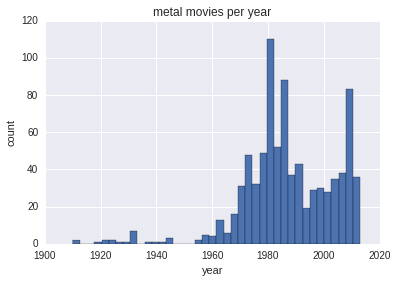

In [7]:
plt.hist(yrlist, bins=40)
plt.xlabel("year")
plt.ylabel("count")
plt.title("metal movies per year")
plt.show()

##### Challenge 2
Find the cast member that appeared in most Heavy Metal movies. Is
there one that is shared by more than one of these movies? Or are they
all completely different actors for every movie?

In [10]:
pipeline = [
        {"$unwind": "$cast"},
        {"$group": {"_id": "$cast", "count": {"$sum": 1}}},
        {"$sort": SON([("count", -1), ("_id", -1)])}
]

In [14]:
list(hmm.aggregate(pipeline))[1]

{u'_id': u'Alice Cooper', u'count': 15}

##### Challenge 3
Find the most used words in Heavy Metal film titles. Is there a word
that appears in a lot of them? Is it "The"? If it is something like
"the", How can you get around that? Find one "meaningful" word that
appears the most (this means non-structural word, unlike "the" or "a"
or "in")

In [135]:
mapper = Code("""
              function () {
                  this.title.replace(/[.,-\/#!$%\^&\*;:{}=\-_`~()]/g,"").split(" ").forEach(function(z) {
                      
                       if (z.length > 3){
                           emit(z, 1);
                       }
                  });
              }
               """)

In [136]:
reducer = Code("""
                function (key, values) {
                  var total = 0;
                  for (var i = 0; i < values.length; i++) {
                    total += values[i];
                  }
                  return total;
                }
                """)

In [137]:
result = hmm.map_reduce(mapper, reducer, "results")

In [138]:
for r in result.find().sort("value", -1).limit(10):
    print r

{u'_id': u'METAL', u'value': 36.0}
{u'_id': u'DEAD', u'value': 24.0}
{u'_id': u'HEAVY', u'value': 19.0}
{u'_id': u'ROCK', u'value': 19.0}
{u'_id': u'BLACK', u'value': 14.0}
{u'_id': u'BLOOD', u'value': 14.0}
{u'_id': u'LAST', u'value': 13.0}
{u'_id': u'NIGHT', u'value': 13.0}
{u'_id': u'DEATH', u'value': 12.0}
{u'_id': u'DEVIL', u'value': 12.0}


##### Challenge 4
METAL CRED section lists themes included in these movies that makes
them more metal.
What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In
2000s?

In [147]:
def metal_cred(yrstart, yrend):
    mappermc = Code("""
                    function () {
                        this.metal_cred.forEach(function(z) {
                            if (z.replace(/[.,-\/#!$%\^&\*;:{}=\-_`~()\\n]/g," ") != 'METAL CRED'){
                                emit(z, 1);
                            }
                        });
                    }
                   """)
    reducermc = Code("""
                     function (key, values) {
                      var total = 0;
                      for (var i = 0; i < values.length; i++) {
                        total += values[i];
                      }
                      return total;
                    }
                    """)
    resultmc = hmm.map_reduce(mappermc, reducermc, "results", query={"$and": [{"year": {"$gte": yrstart}},{"year":{"$lt": yrend}}]}) #query={"year": {"$gte": yrstart, "$lt": yrend}}) 
    return resultmc

In [148]:
yrslist = [1970, 1980, 1990, 2000, 2010]
for y1, y in enumerate(yrslist[:-1]):
    print "\n", y, yrslist[y1+1]
    resultmc = metal_cred(y, yrslist[y1+1])
    for r in resultmc.find().sort("value", -1).limit(5):
        #print(str(r["_id"])  + "\t" + str(r["value"]))
        print r


1970 1980
{u'_id': u'Satan', u'value': 19.0}
{u'_id': u'Black Mass', u'value': 10.0}
{u'_id': u'Post-Apocalypse', u'value': 7.0}
{u'_id': u'Video Nasty', u'value': 7.0}
{u'_id': u'Giallo', u'value': 6.0}

1980 1990
{u'_id': u'Post-Apocalypse', u'value': 29.0}
{u'_id': u'Sword and Sorcery', u'value': 20.0}
{u'_id': u'Satan', u'value': 16.0}
{u'_id': u'Video Nasty', u'value': 12.0}
{u'_id': u'Zombies', u'value': 11.0}

1990 2000
{u'_id': u'Satan', u'value': 7.0}
{u'_id': u'Gwar', u'value': 6.0}
{u'_id': u'Lemmy', u'value': 4.0}
{u'_id': u'Post-Apocalypse', u'value': 4.0}
{u'_id': u'Alice Cooper', u'value': 3.0}

2000 2010
{u'_id': u'Torture Porn', u'value': 11.0}
{u'_id': u'Satan', u'value': 7.0}
{u'_id': u'Jigsaw', u'value': 4.0}
{u'_id': u'Music Score: Charlie Clouser', u'value': 4.0}
{u'_id': u'Rob Zombie', u'value': 4.0}


##### Challenge 5
Let's use the length of the METAL CRED section as a proxy score for
how metal a movie is. Let's call this the METAL SCORE. To each mongo
document, add the metal_score as a new field.

##### Challenge 6
Find the director that is MOST METAL per movie (director with the
highest average metal score).
Remember that some movies have multiple directors.

##### Challenge 7
The majority of directors and actors will have worked on a single
movie. See if there are any directors that worked with an actor more
than once. If so, find the director-actor duo that have worked
together the most times.

##### Challenge 8
Create an index on the 'director' field to make the queries involving
it faster.
[What is an index?](http://en.wikipedia.org/wiki/Database_index)

[Creating an index in mongo](http://docs.mongodb.org/manual/tutorial/create-an-index/)
[Creating an index in pymongo](http://api.mongodb.org/python/current/api/pymongo/collection.html?highlight=create_index#pymongo.collection.Collection.create_index)
[Single field index on mongo](http://docs.mongodb.org/manual/core/index-single/)
[Mongo documentation on indexes](http://docs.mongodb.org/manual/core/indexes/)

##### Challenge 9 (Optional challenge for early finishers)
For each decade, make a histogram of metal scores.
Also, calculate the average metal score for each decade. Which decade
was the most pure metal decade?

##### Note (rather than a challenge)
In the latest version of mongo, you can do a text query.
To do this, you need to create one (only one) text-based index.
Let's index the_meat field so we can make text search queries on it
(in pymongo):

db.reviews.create_index([("the_meat", pymongo.TEXT,)])

Now you can do text search. For example, let's search for the phrase
"hitting power chords" within "the_meat" fields of all our documents.

    db.reviews.find({"$text": {"$search": "hitting power
    chords"}}).count()

    206

It has found 206 reviews. I can print the titles of the first 10
reviews that were returned in this text search:

    ten_matches = r.find({"$text": {"$search": "hitting power chords"}}).limit(10)
    for match in ten_matches:
        print match["title"]


    DOMINATOR
    REPO: THE GENETIC OPERA
    GREMLINS 2: THE NEW BATCH
    VICE SQUAD
    THE JERKY BOYS: THE MOVIE
    THE SONG REMAINS THE SAME
    THE EXORCIST
    THE CROW
    CANNIBAL HOLOCAUST
    HOSTEL

Enjoy your text searches : ) These can be very useful in some apps.



### Twitter API Extension

Create a mongo collection of tweets about something (anything you
choose).

Each mongo document should contain the text, username, favorite count
and retweet count of the tweet.